# Neurons example, pt. 1
## Generate some data

In [1]:
from bayes_window import models, fake_spikes_explore, BayesWindow
from bayes_window.generative_models import generate_fake_spikes
from importlib import reload
import numpy as np
import altair as alt
alt.data_transformers.disable_max_rows()
try:
    alt.renderers.enable('altair_saver', fmts=['png'])
except Exception:
    pass

In [2]:

df, df_monster, index_cols, firing_rates = generate_fake_spikes(n_trials=20,
                                                                n_neurons=6,
                                                                n_mice=3,
                                                                dur=5,
                                                               mouse_response_slope=40,
                                                               overall_stim_response_strength=5)


## Exploratory plot without any fitting

Three mice, five neurons each. Mouse #0/neuron #4 has the least effect, mouse #2/neuron #0 the most

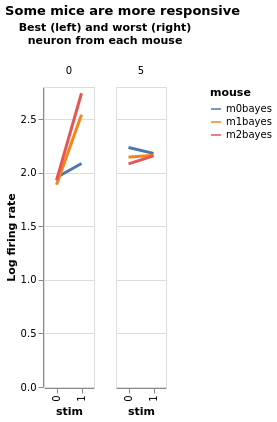

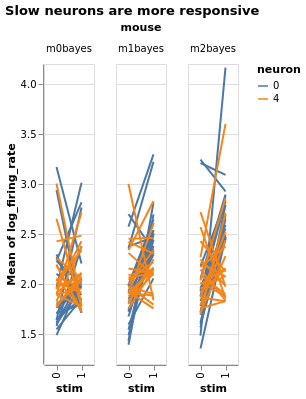

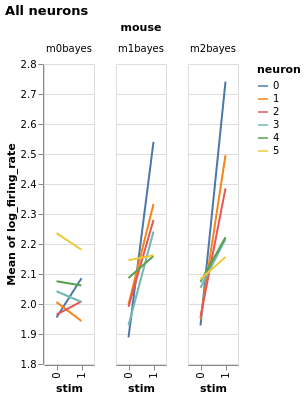

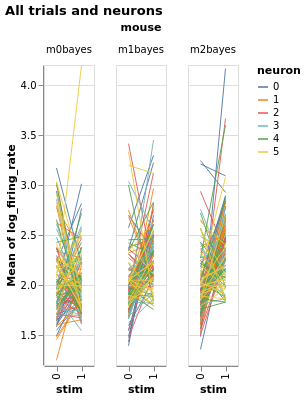

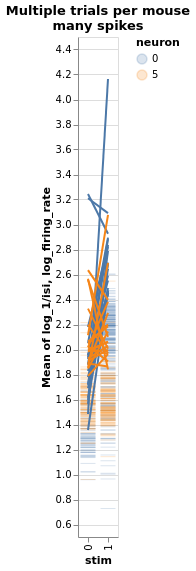

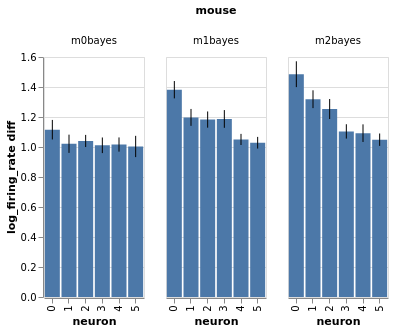

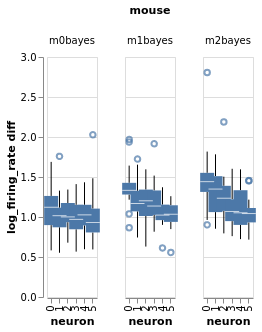

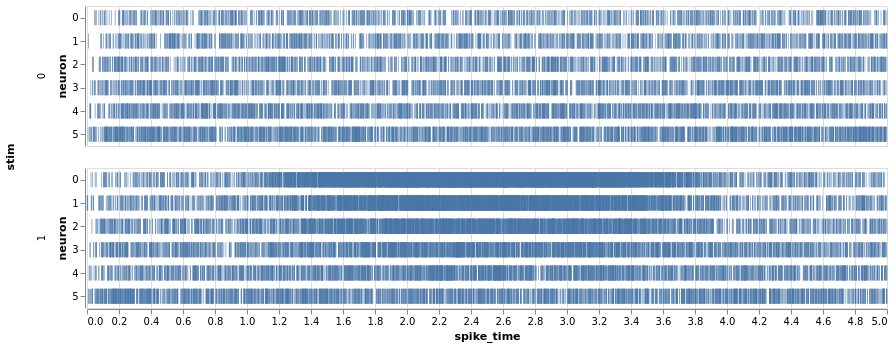

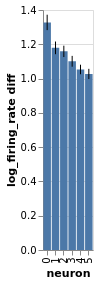

In [3]:

charts=fake_spikes_explore(df,df_monster,index_cols)
[chart.display() for chart in charts];
#fig_mice, fig_select, fig_neurons, fig_trials, fig_isi + fig_overlay, bar, box, fig_raster, bar_combined

## Estimate with neuron as condition

### ISI

In [4]:
df['log_isi']=np.log10(df['isi'])

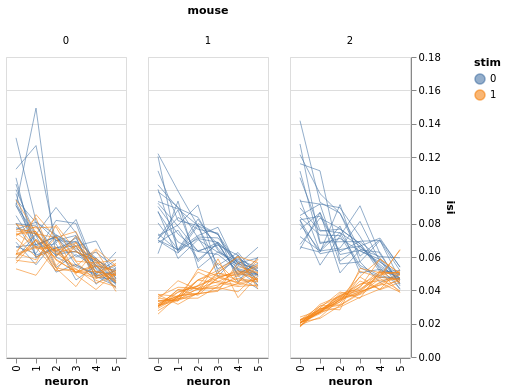

In [5]:
bw = BayesWindow(df_monster, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.plot(x='neuron',color='stim',detail='i_trial',add_box=False).facet(column='mouse',)

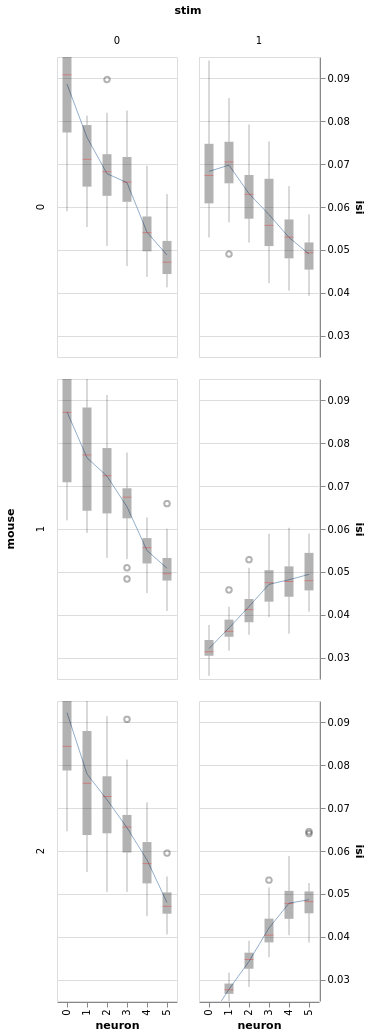

In [6]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.plot(x='neuron',add_box=True).facet(row='mouse',column='stim')

## Vanilla regression

In [7]:
bw.levels

['stim', 'neuron', 'mouse', 'mouse']

n(Divergences) = 60
neuron:O
neuron:O


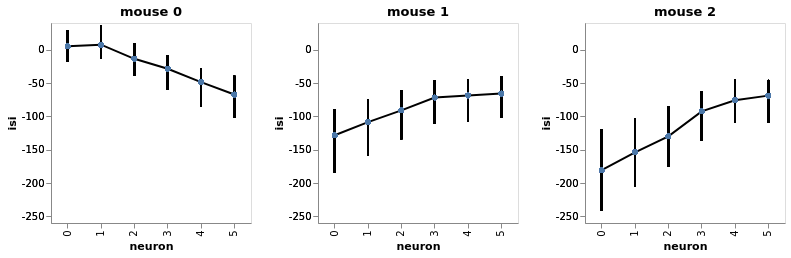

In [8]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse', detail='i_trial')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='normal',
              robust_slopes=False,
              add_group_slope=False,
              add_group_intercept=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse', 'i_trial')
             )

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)


bw.facet(column='mouse',width=200,height=200).display()

## GLM
($y\sim Gamma(\theta)$)

n(Divergences) = 71
neuron:O
neuron:O


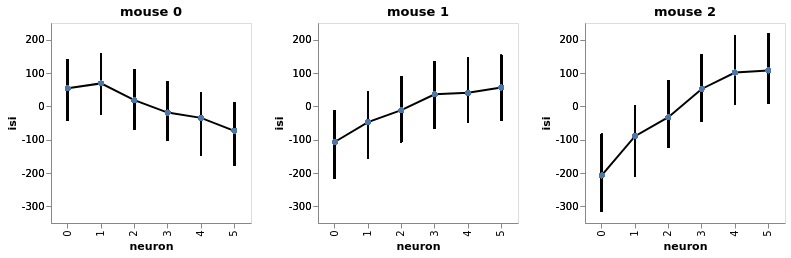

In [9]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse', detail='i_trial')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='gamma',
              robust_slopes=False,
              add_group_slope=True,
              add_group_intercept=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse','i_trial'))

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)


bw.facet(column='mouse',width=200,height=200).display()

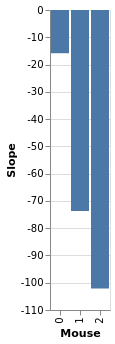

In [10]:
import altair as alt
slopes=bw.trace.posterior['slope_per_group'].mean(['chain','draw']).to_dataframe().reset_index()
chart_slopes=alt.Chart(slopes).mark_bar().encode(
    x=alt.X('mouse_:O',title='Mouse'),
    y=alt.Y('slope_per_group', title='Slope')
)
chart_slopes

In [11]:
bw = BayesWindow(df, y='firing_rate', treatment='stim', condition='neuron_x_mouse', group='mouse',)
#bw.fit_anova()
bw.fit_lme()

Using formula firing_rate ~ (1|mouse) + stim| neuron_x_mouse__0 + stim|neuron_x_mouse__1 + stim|neuron_x_mouse__2 + stim|neuron_x_mouse__3 + stim|neuron_x_mouse__4 + stim|neuron_x_mouse__5 + stim|neuron_x_mouse__6 + stim|neuron_x_mouse__7 + stim|neuron_x_mouse__8 + stim|neuron_x_mouse__9 + stim|neuron_x_mouse__10 + stim|neuron_x_mouse__11 + stim|neuron_x_mouse__12 + stim|neuron_x_mouse__13 + stim|neuron_x_mouse__14 + stim|neuron_x_mouse__15 + stim|neuron_x_mouse__16 + stim|neuron_x_mouse__17
                              Coef. Std.Err.       z  P>|z|    [0.025   0.975]
Intercept                     2.323   94.071   0.025  0.980  -182.053  186.699
1 | mouse                    94.268   48.402   1.948  0.051    -0.597  189.133
stim | neuron_x_mouse__0     96.038  190.724   0.504  0.615  -277.775  469.851
stim | neuron_x_mouse__1     94.570  190.724   0.496  0.620  -279.243  468.383
stim | neuron_x_mouse__2     19.972  190.724   0.105  0.917  -353.841  393.785
stim | neuron_x_mouse__3     

neuron_x_mouse:O


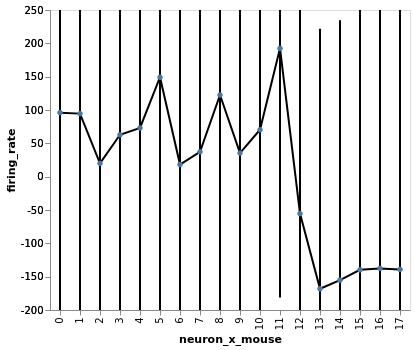

In [12]:
bw.regression_charts(x='neuron_x_mouse:O')

### Firing rate

neuron_x_mouse:O
neuron:O


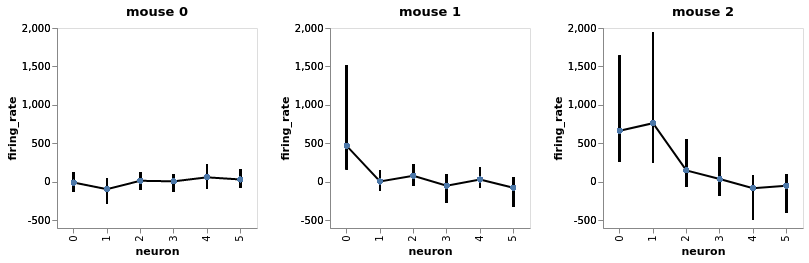

In [13]:
bw = BayesWindow(df, y='firing_rate', treatment='stim', condition='neuron_x_mouse', group='mouse')
bw.fit_slopes(model=models.model_hierarchical, do_make_change='subtract',
              progress_bar=False,
              dist_y='student',
              add_group_slope=True, add_group_intercept=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)
bw.facet(column='mouse',width=200,height=200).display()

ANOVA may not be appropriate here: It considers every neuron. If we look hard enough, surely we'll find a responsive neuron or two out of hundreds?

In [14]:
bw = BayesWindow(df, y='firing_rate', treatment='stim', condition='neuron_x_mouse', group='mouse')

bw.fit_anova(formula='firing_rate ~ stim+ mouse + stim*mouse + neuron_x_mouse + stim * neuron_x_mouse');

firing_rate ~ stim+ mouse + stim*mouse + neuron_x_mouse + stim * neuron_x_mouse
                         sum_sq   df      F  PR(>F)
stim                     -0.00  1.0  -0.00    1.00
mouse                 50527.92  1.0  20.76    0.04
stim:mouse                2.39  1.0   0.00    0.98
neuron_x_mouse       147806.65  1.0  60.73    0.02
stim:neuron_x_mouse   39436.96  1.0  16.20    0.06
Residual               4867.51  2.0    NaN     NaN


## Model quality

neuron:O


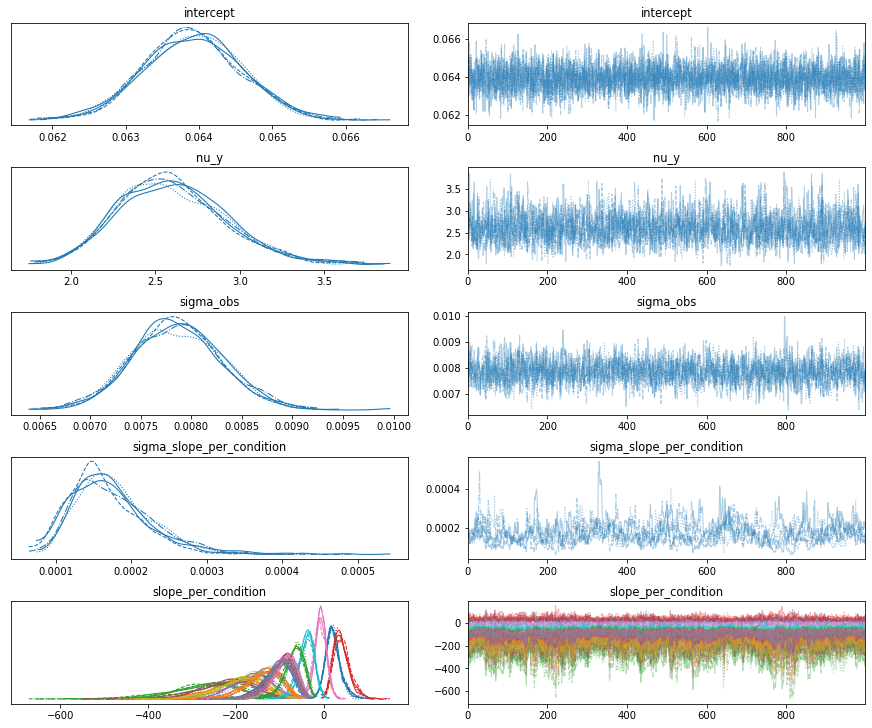

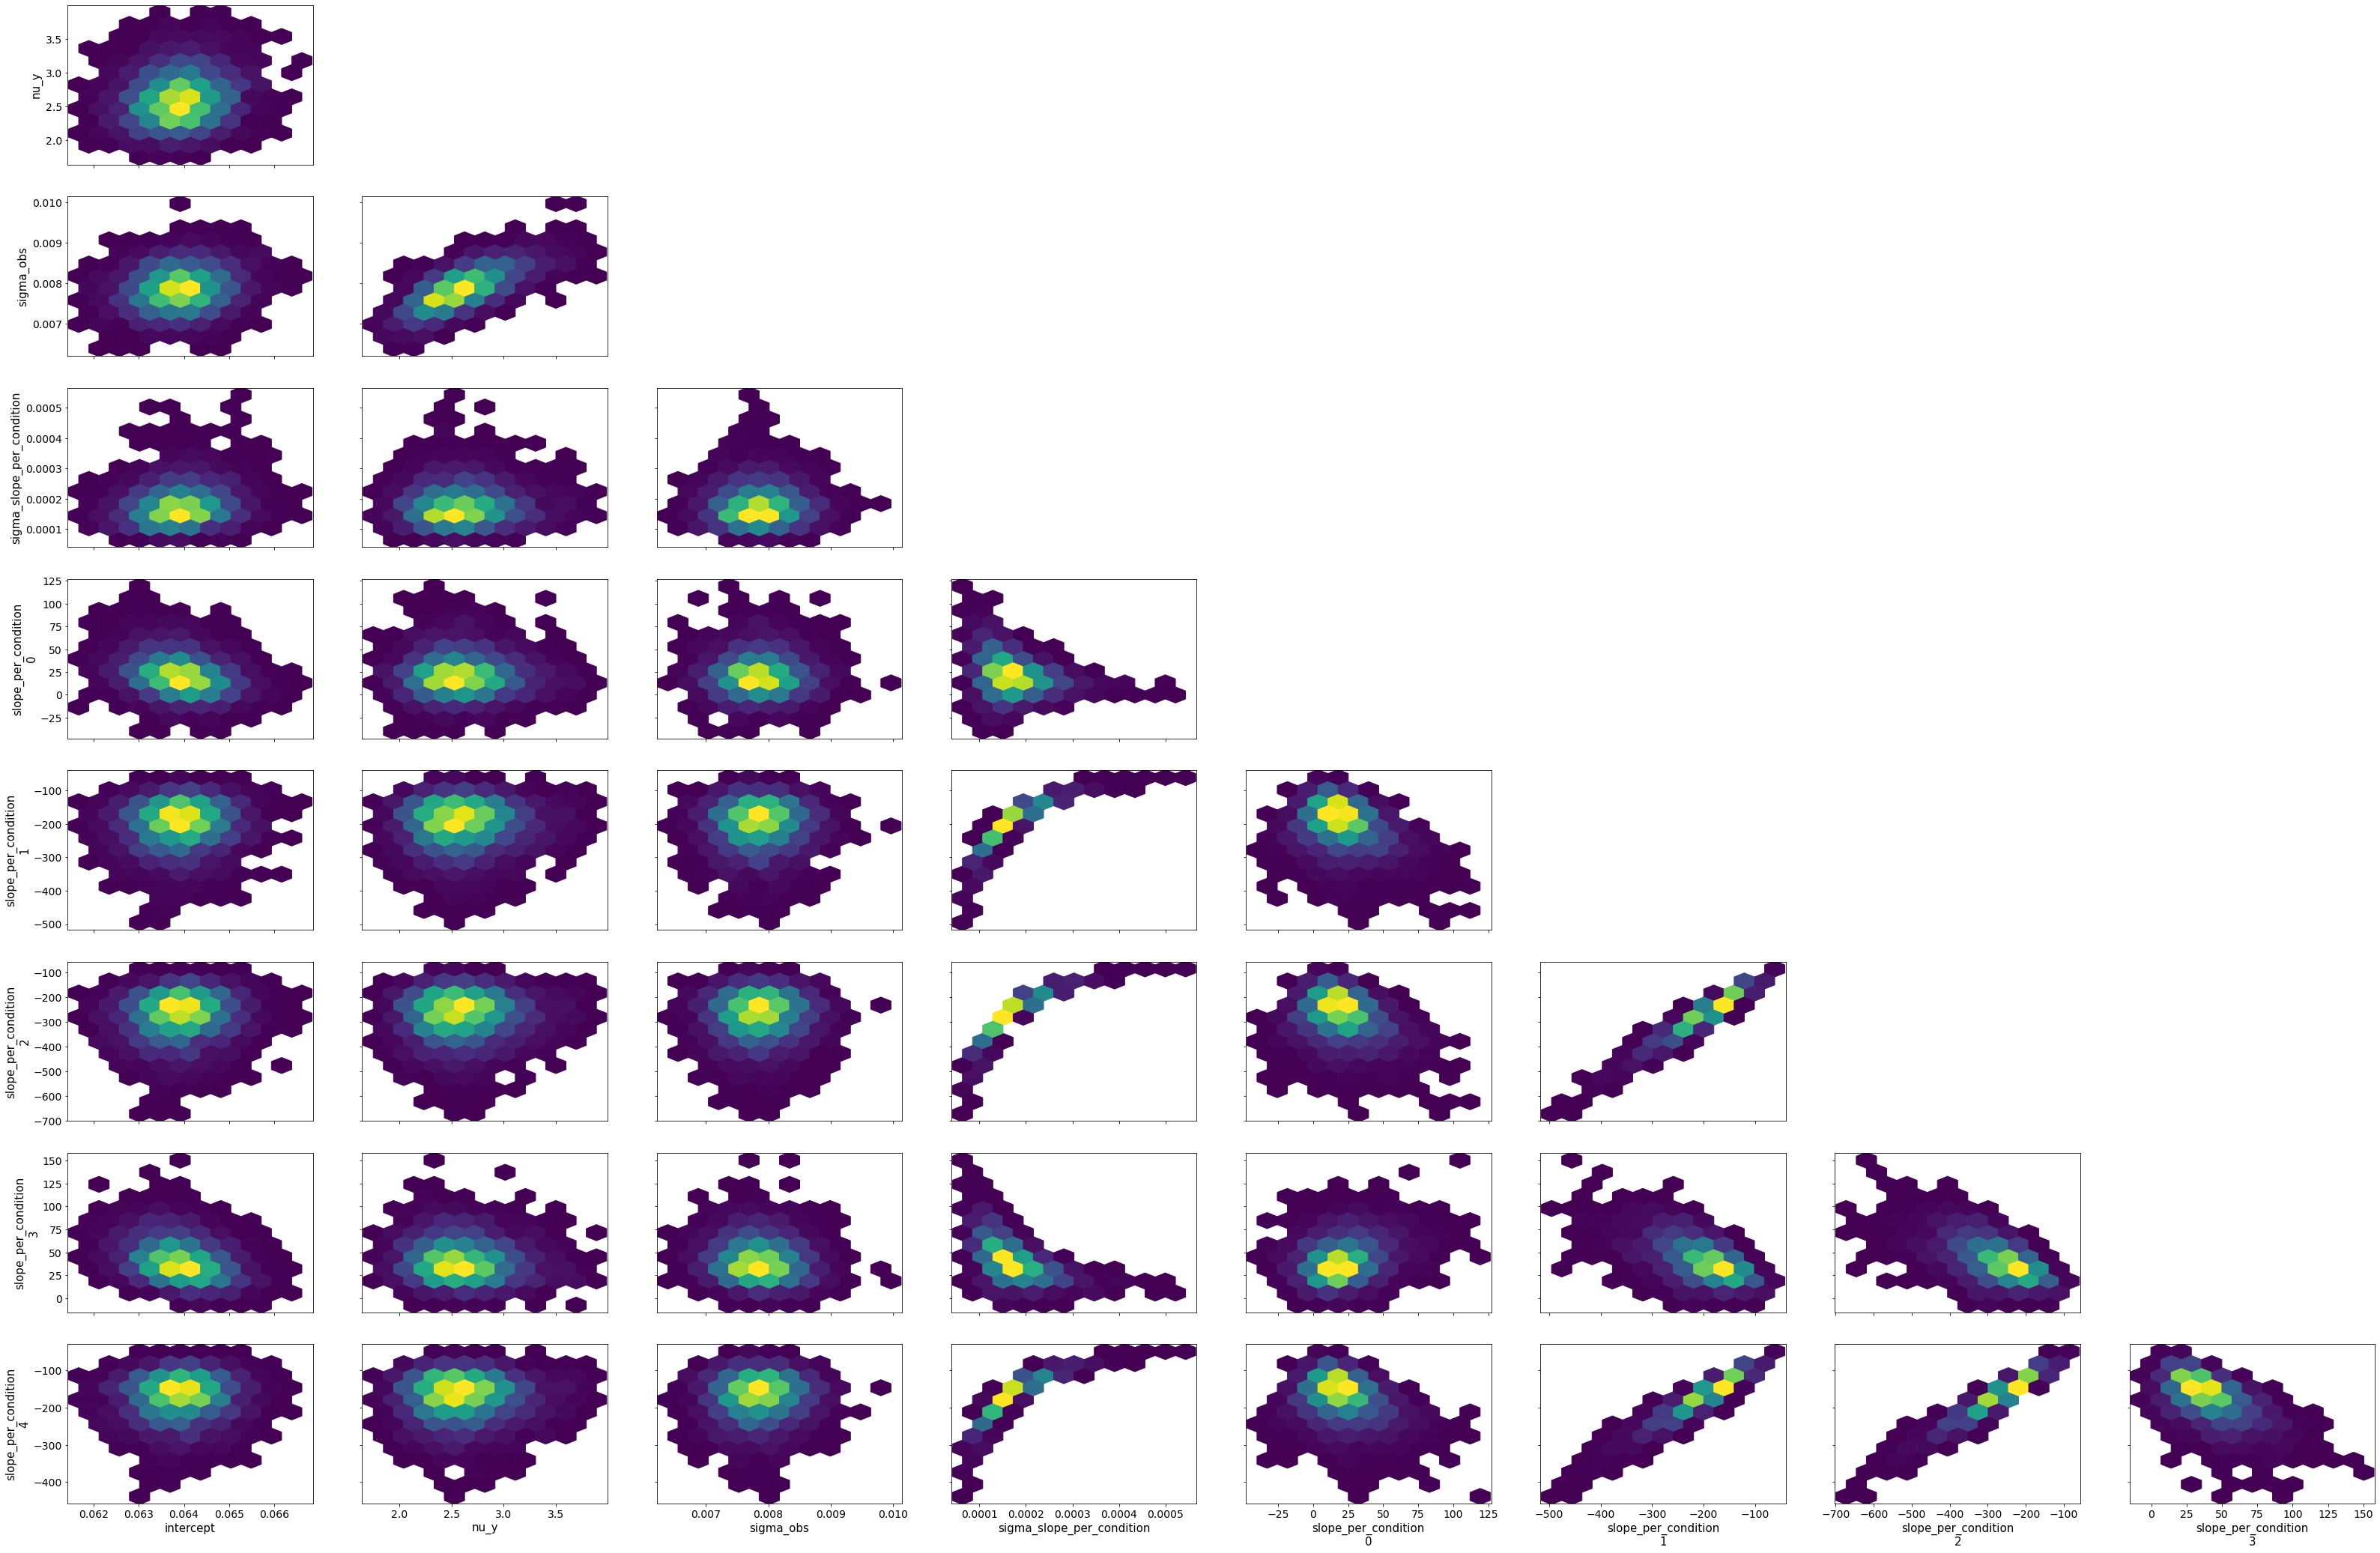

In [15]:
# Vanilla robust no interept or slope
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=True,
              add_group_intercept=False,
              add_group_slope=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

n(Divergences) = 10
neuron:O


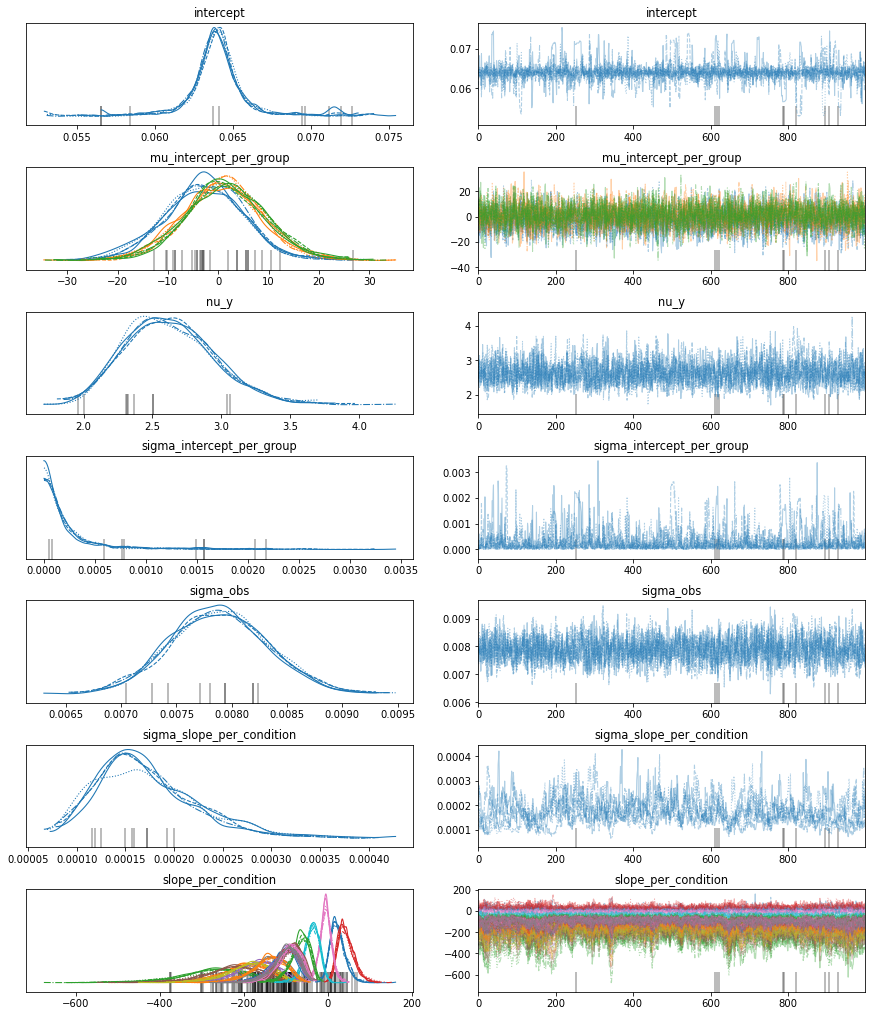

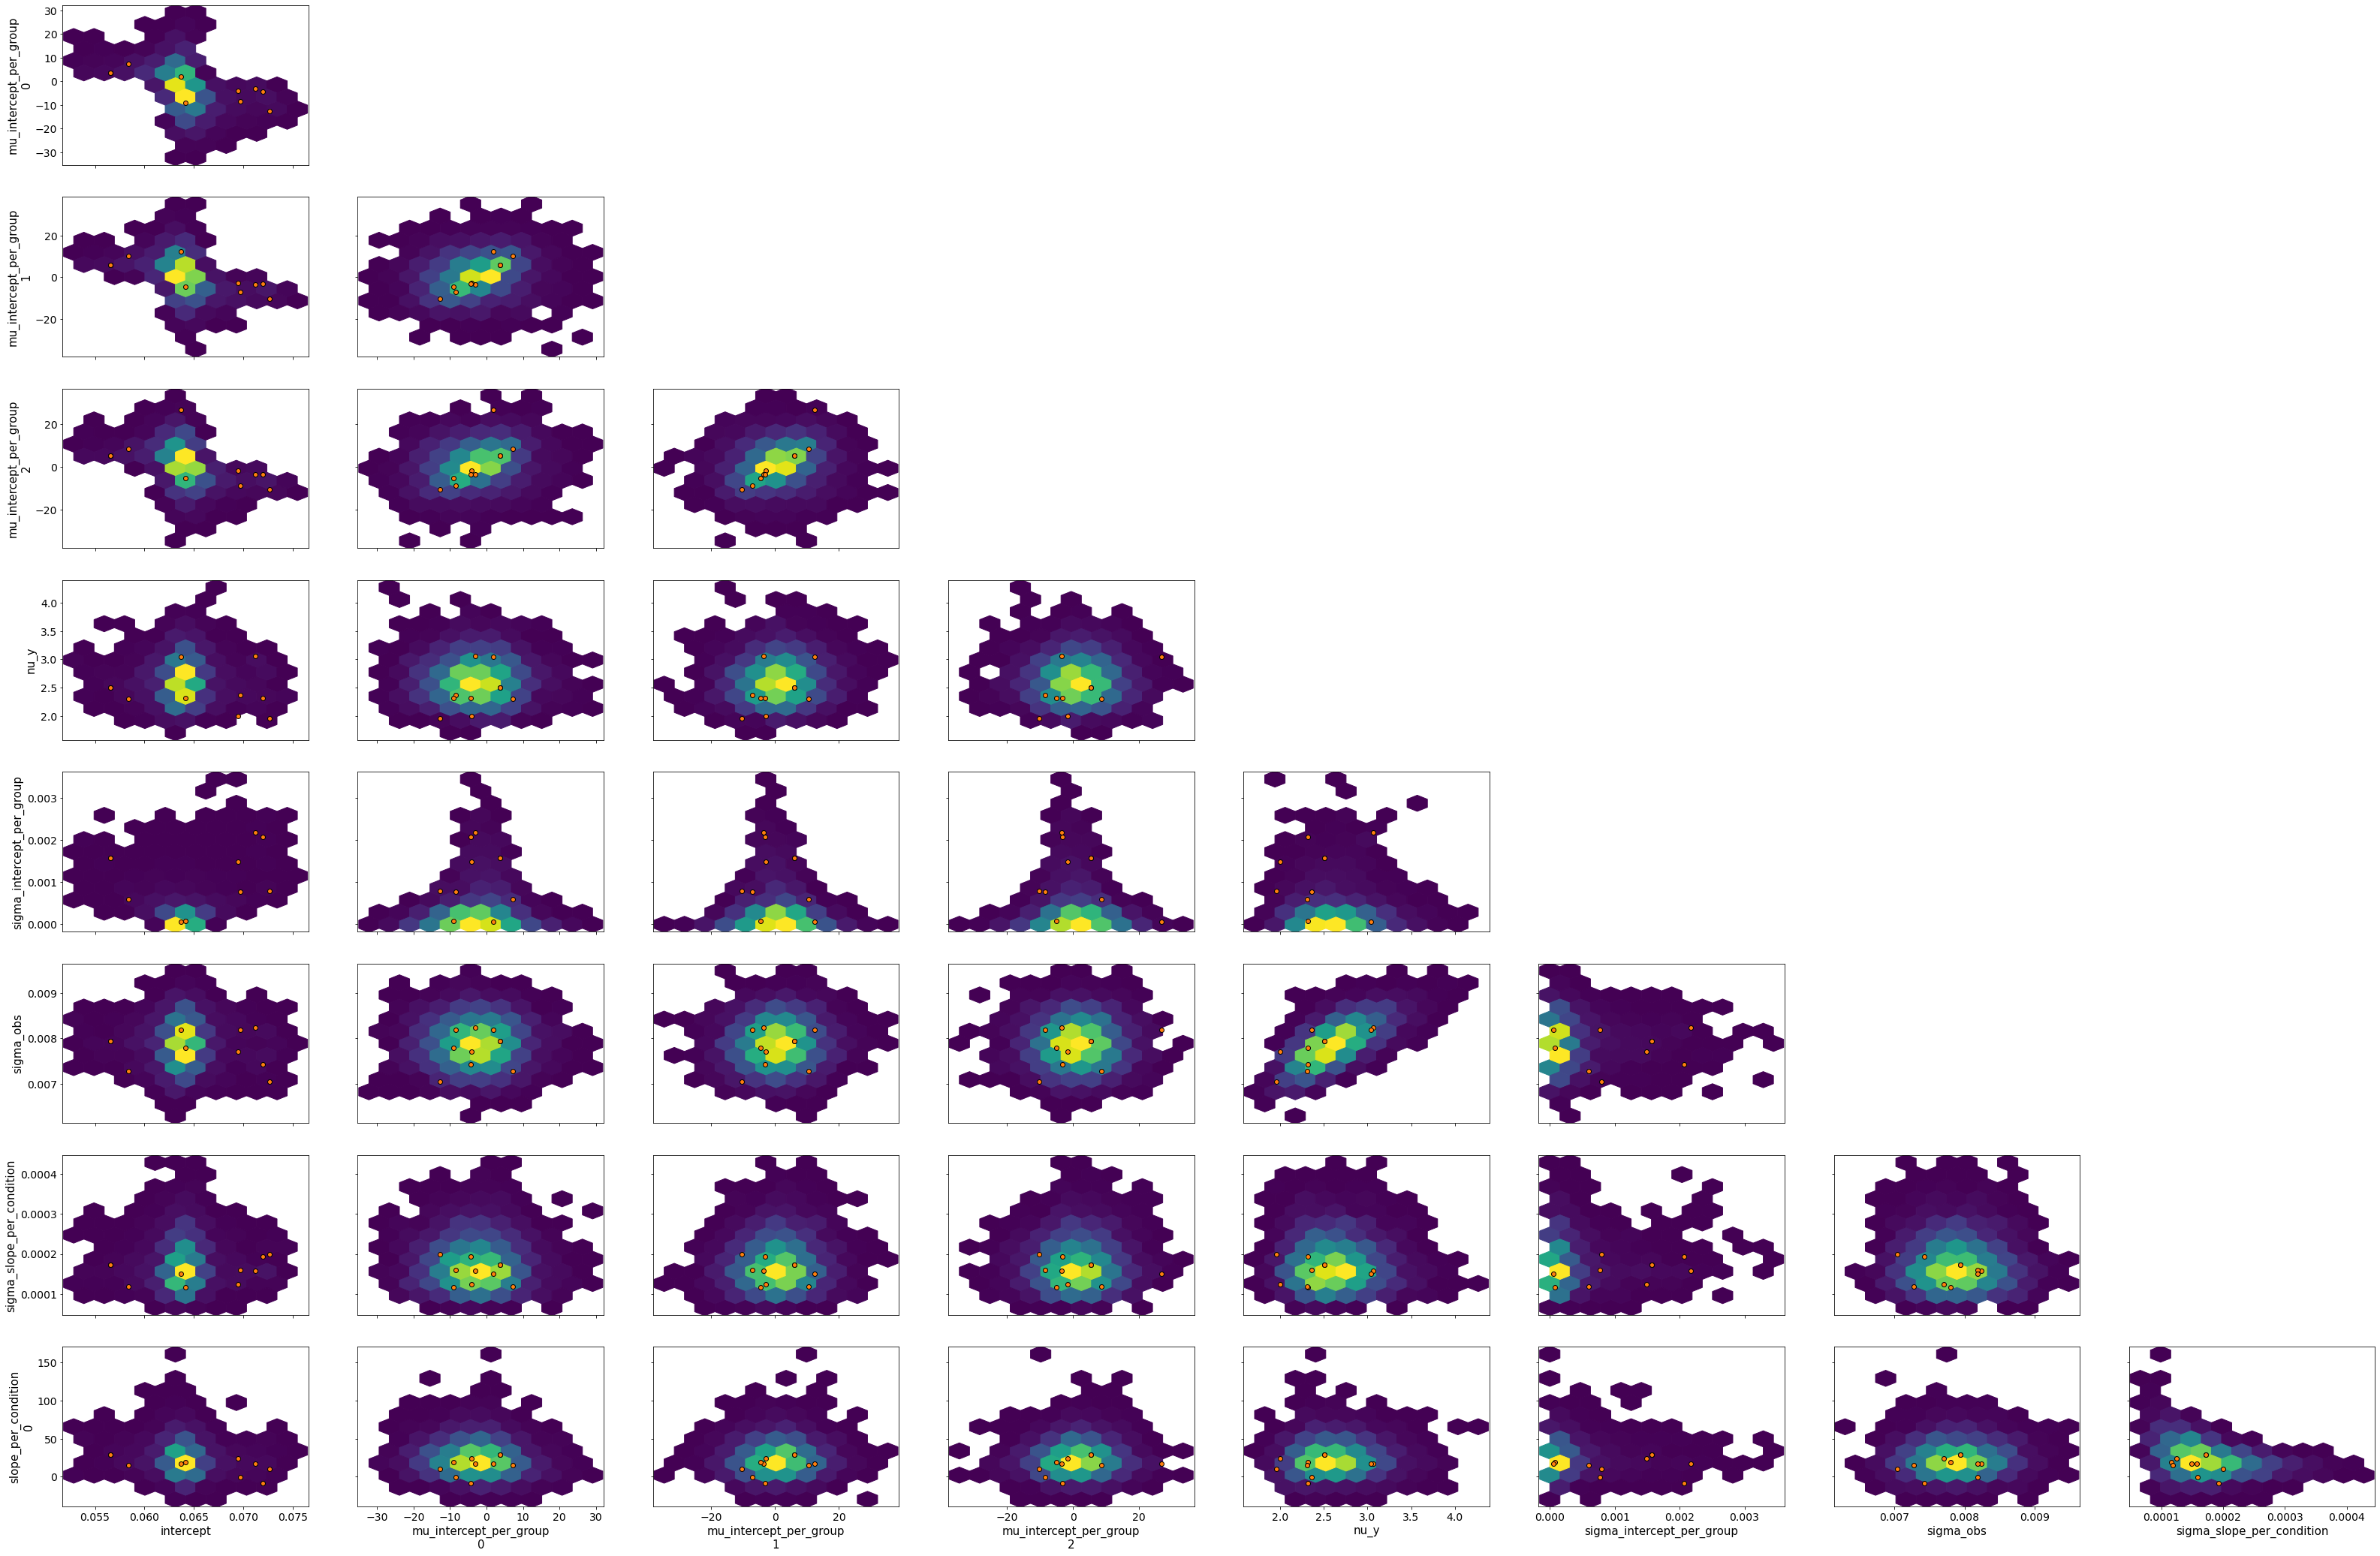

In [16]:
# Vanilla robust, intercept only
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=True,
              add_group_intercept=True,
              add_group_slope=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

neuron:O


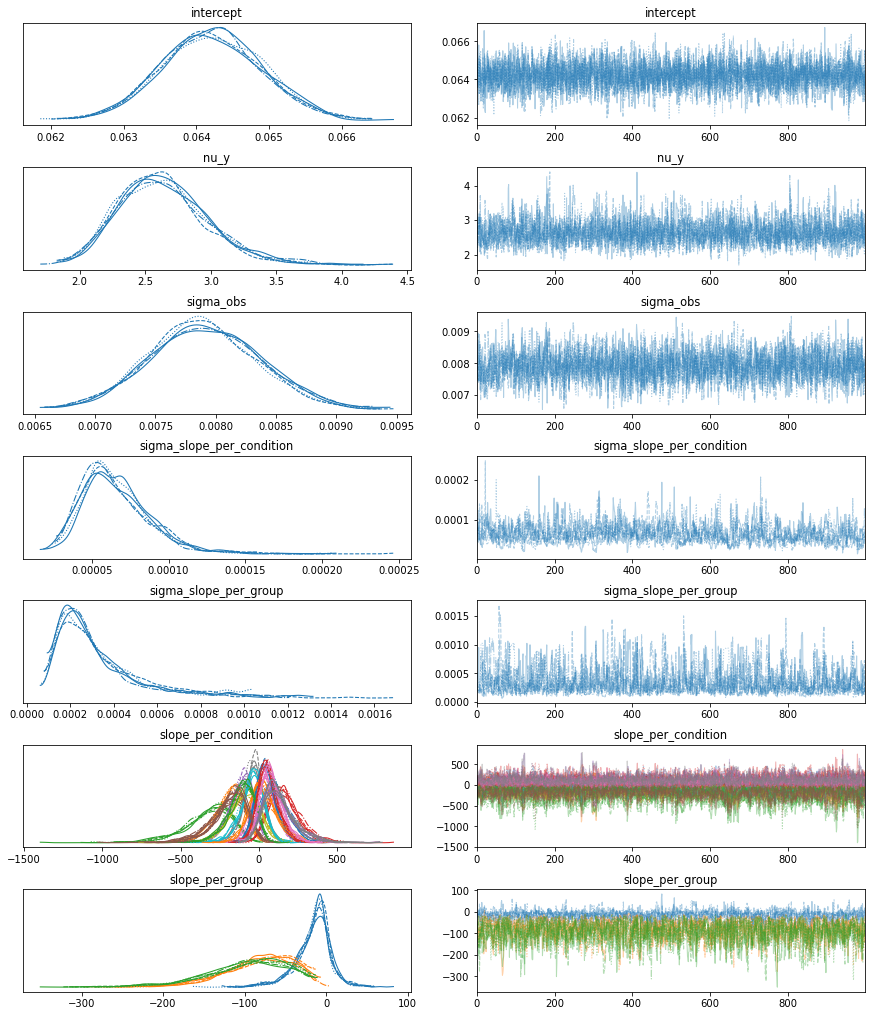

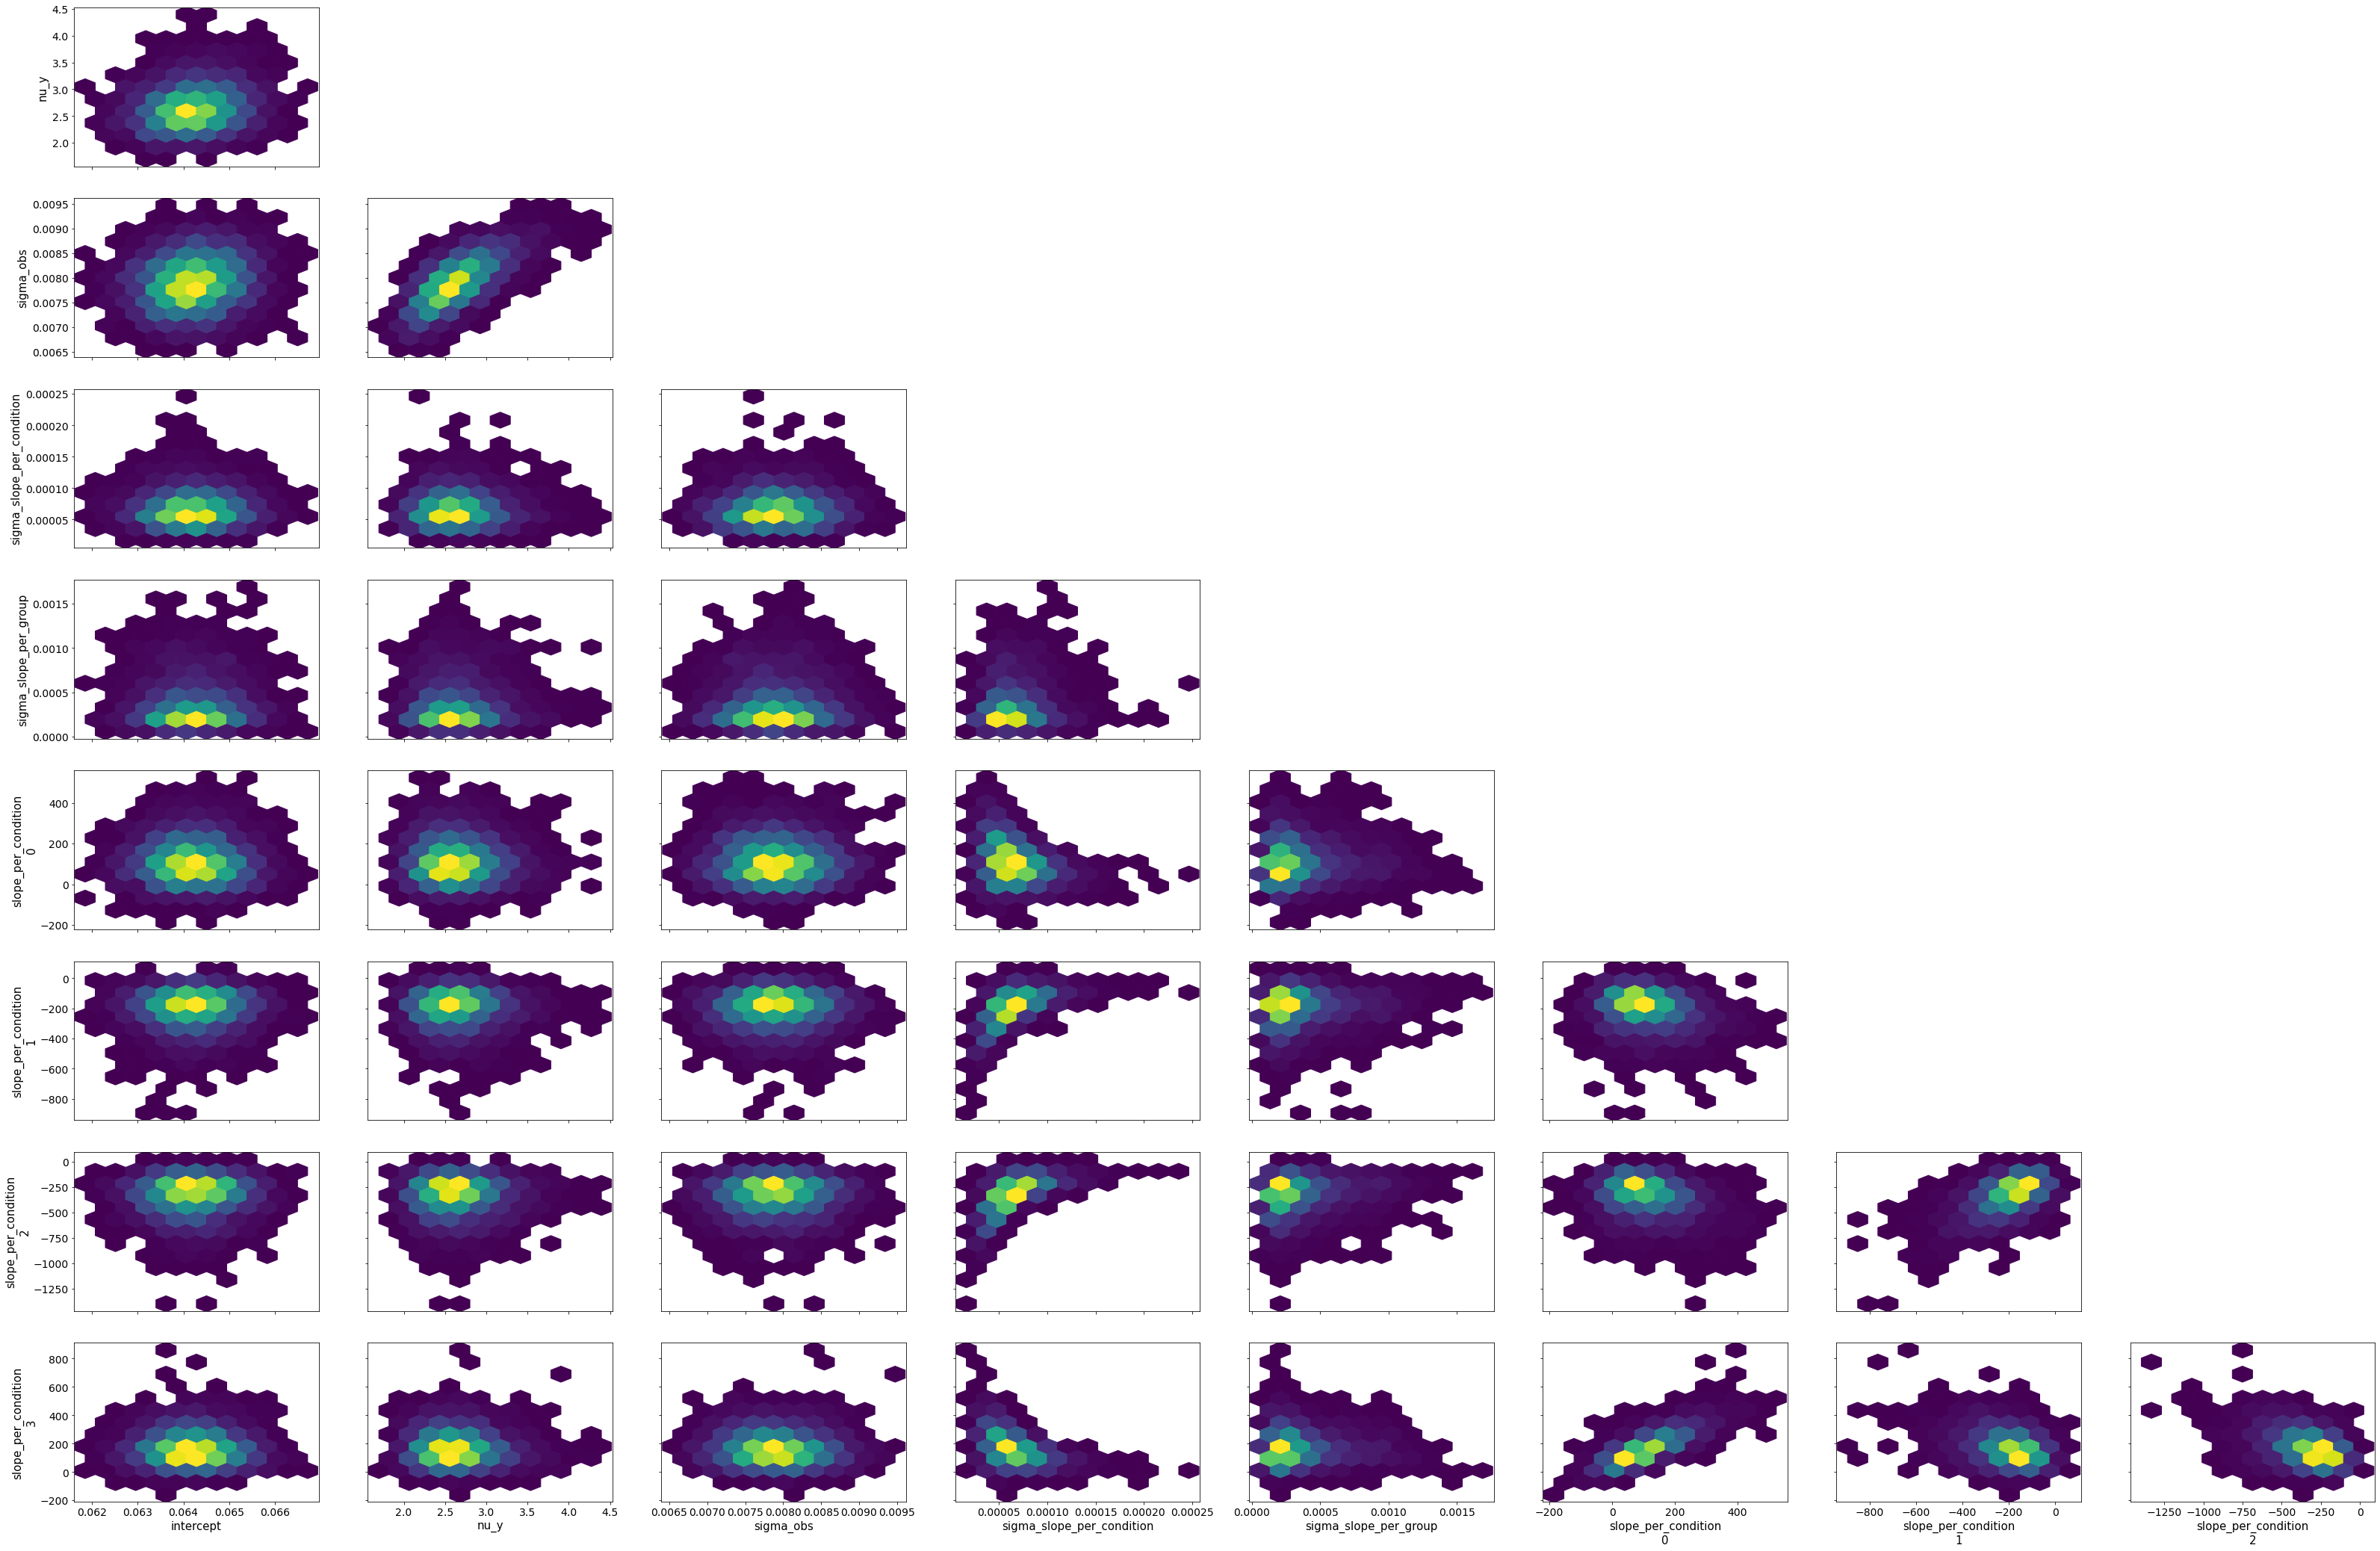

In [17]:
# Vanilla robust, slopes only
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=True,
              add_group_intercept=False,
              add_group_slope=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

n(Divergences) = 3
neuron:O


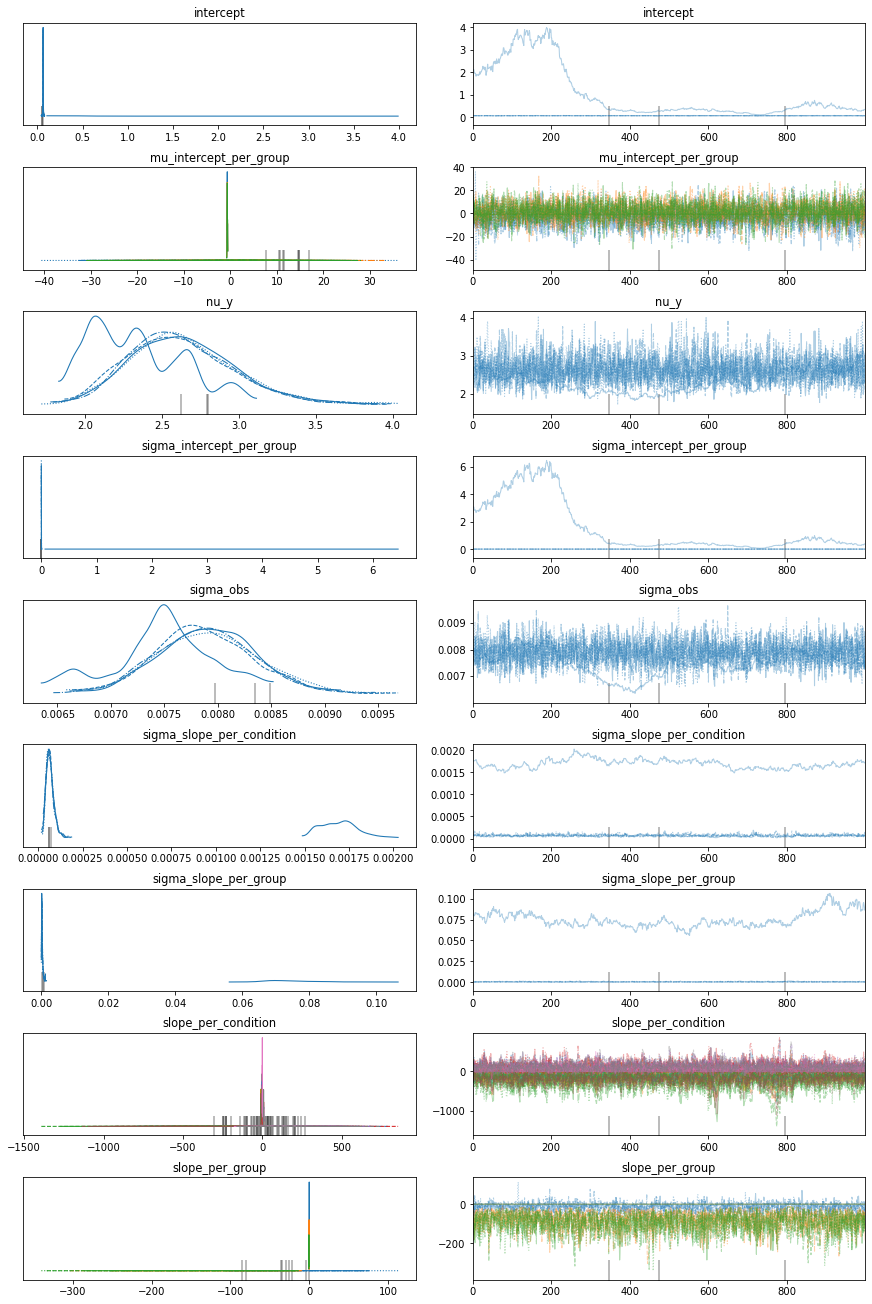

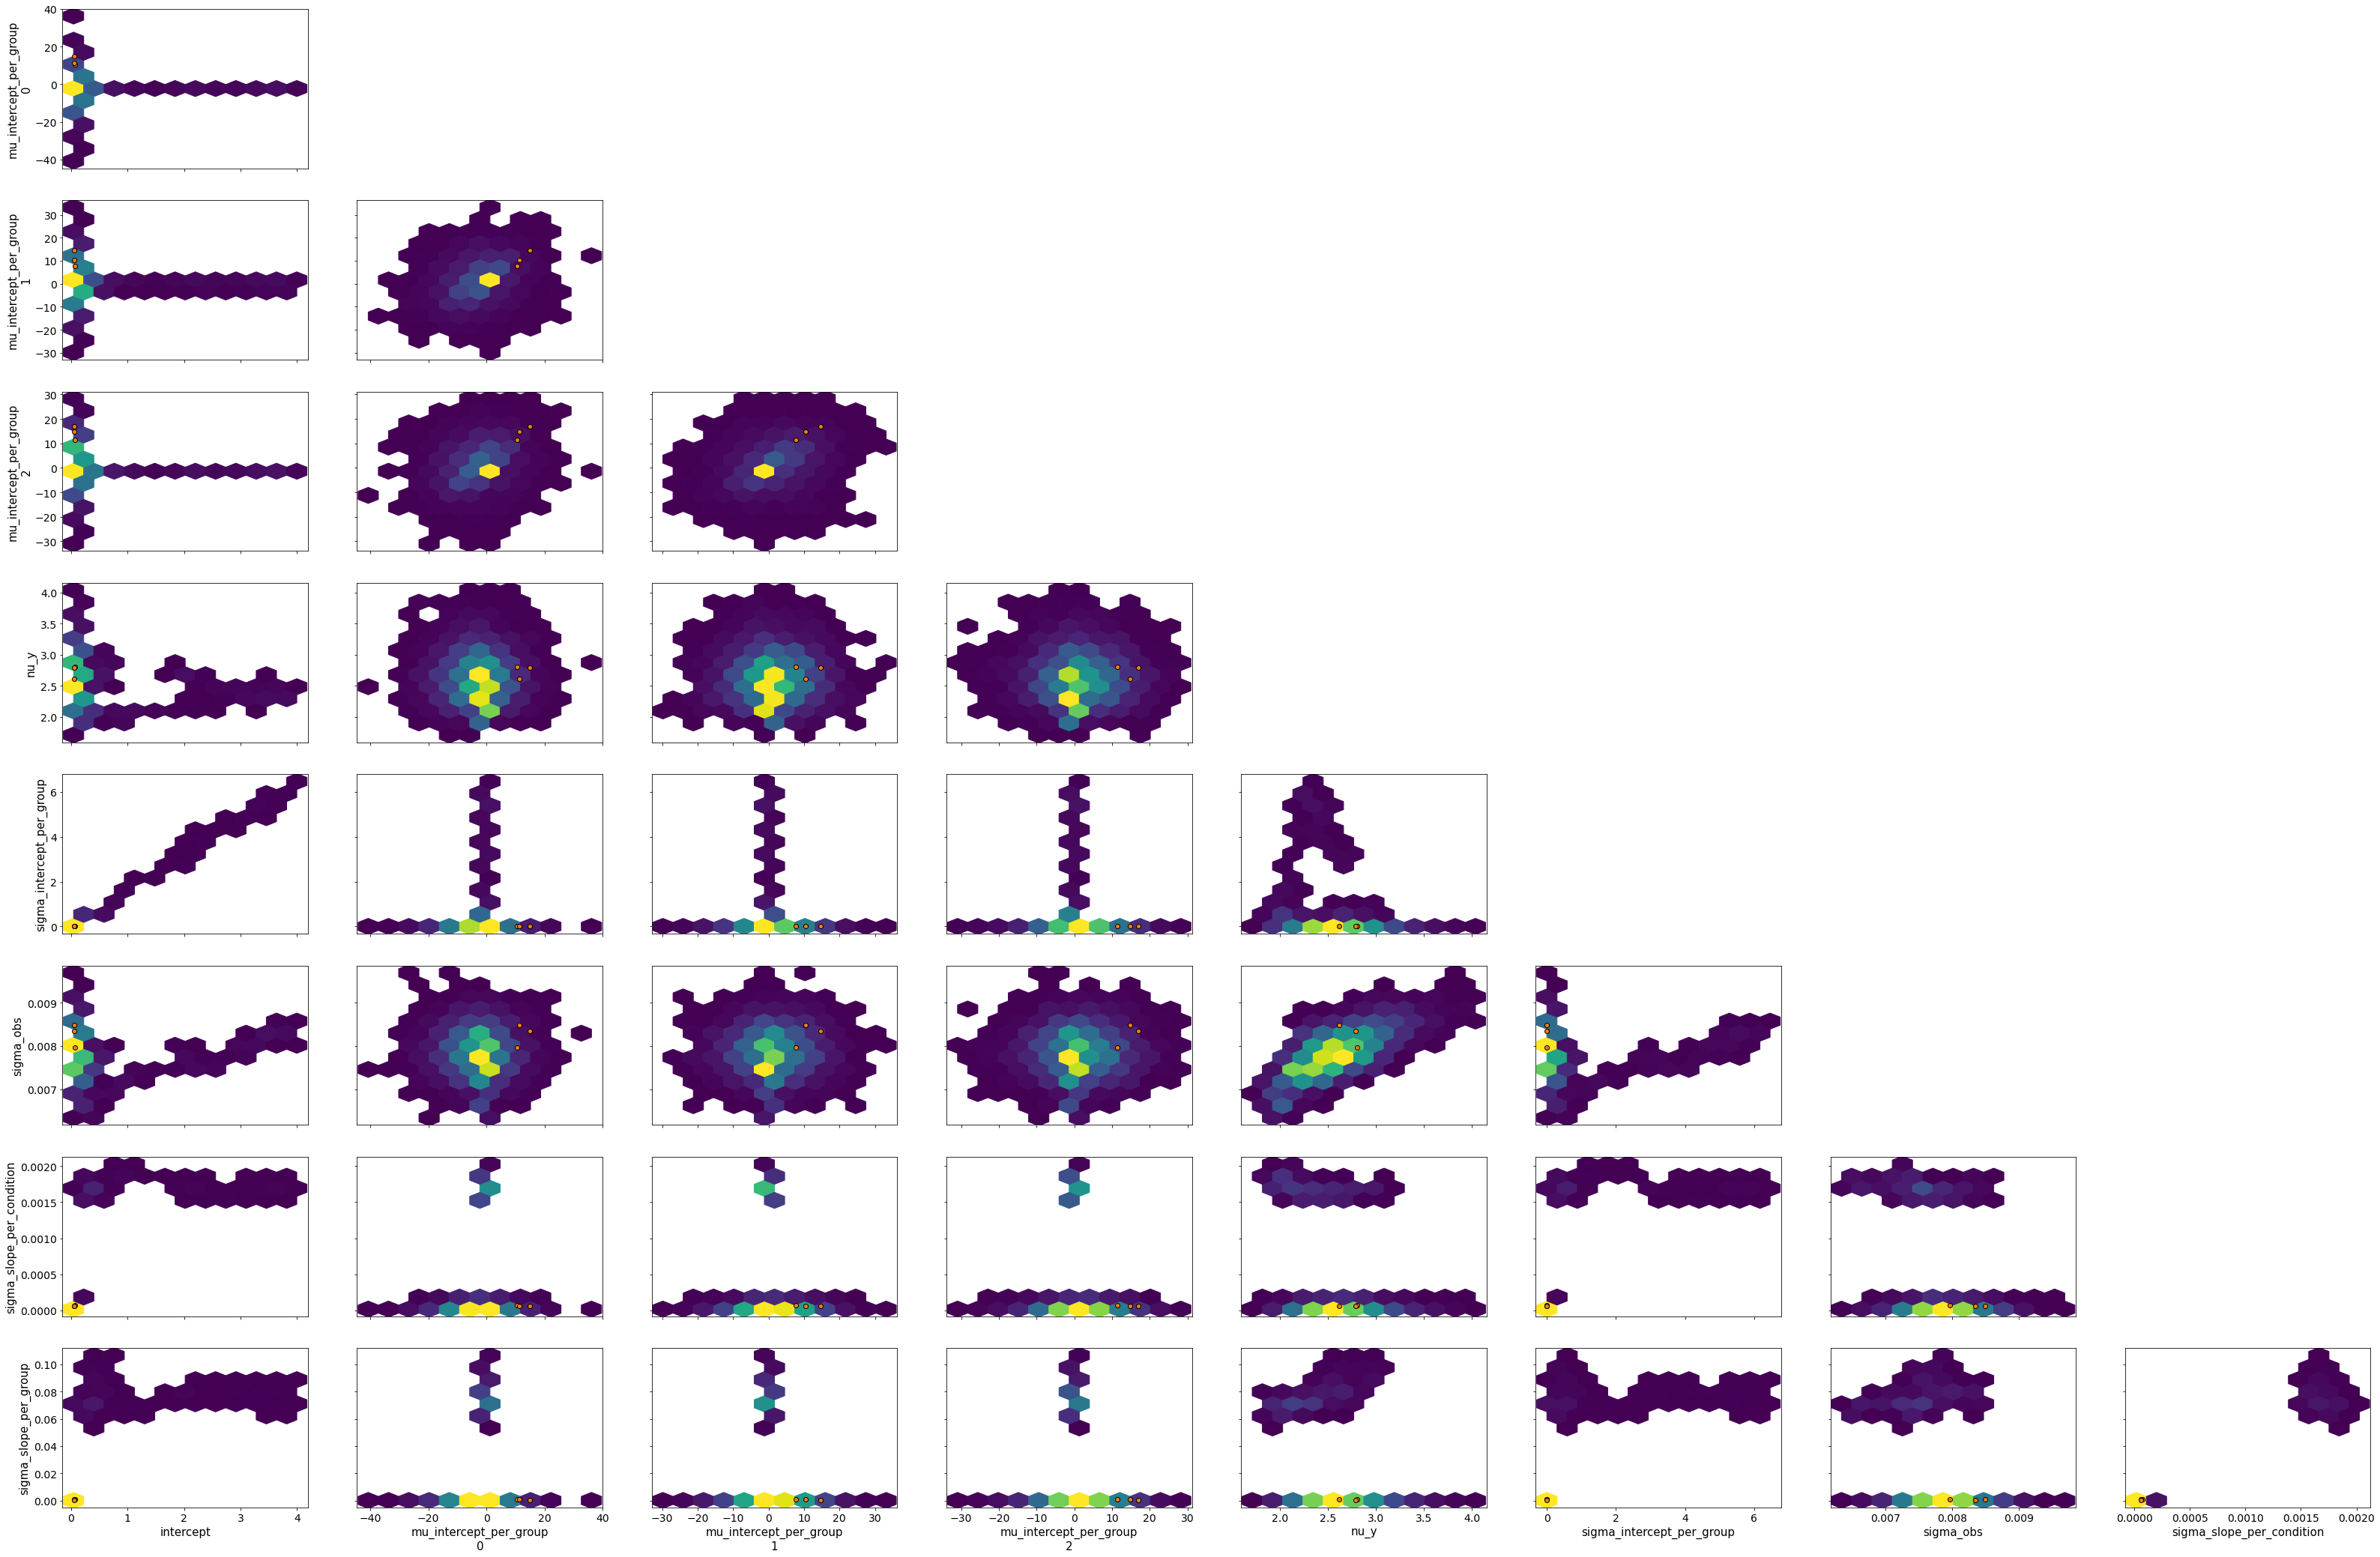

In [18]:
# Vanilla robust intercept and group
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=True,
              add_group_intercept=True,
              add_group_slope=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

n(Divergences) = 78
neuron:O


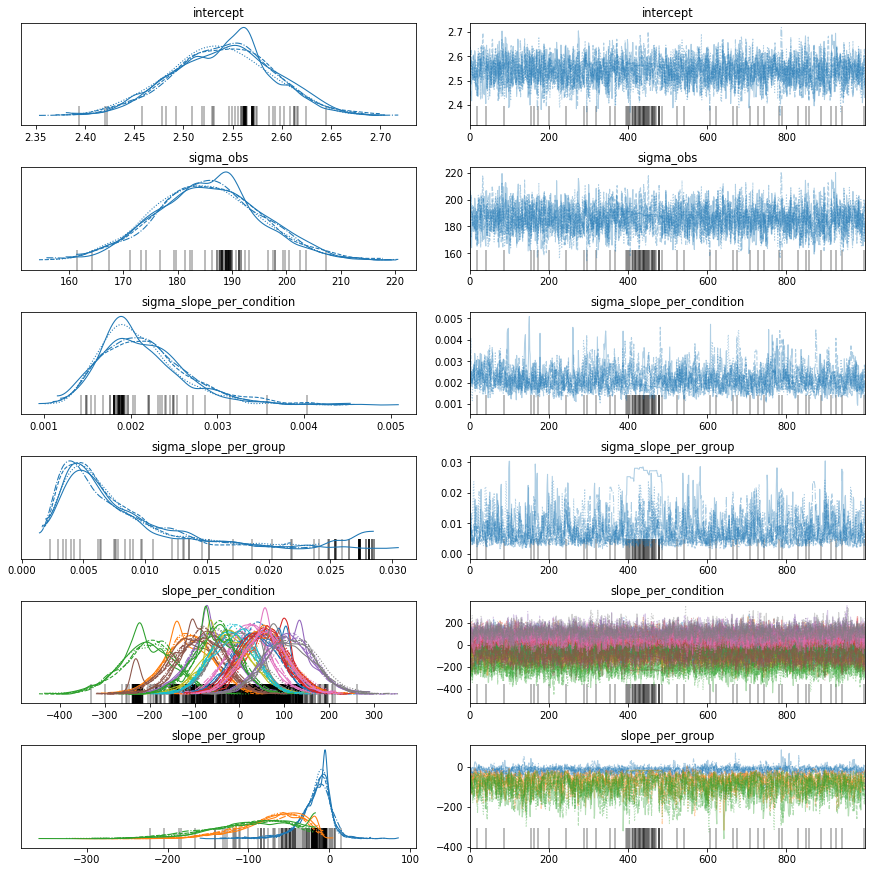

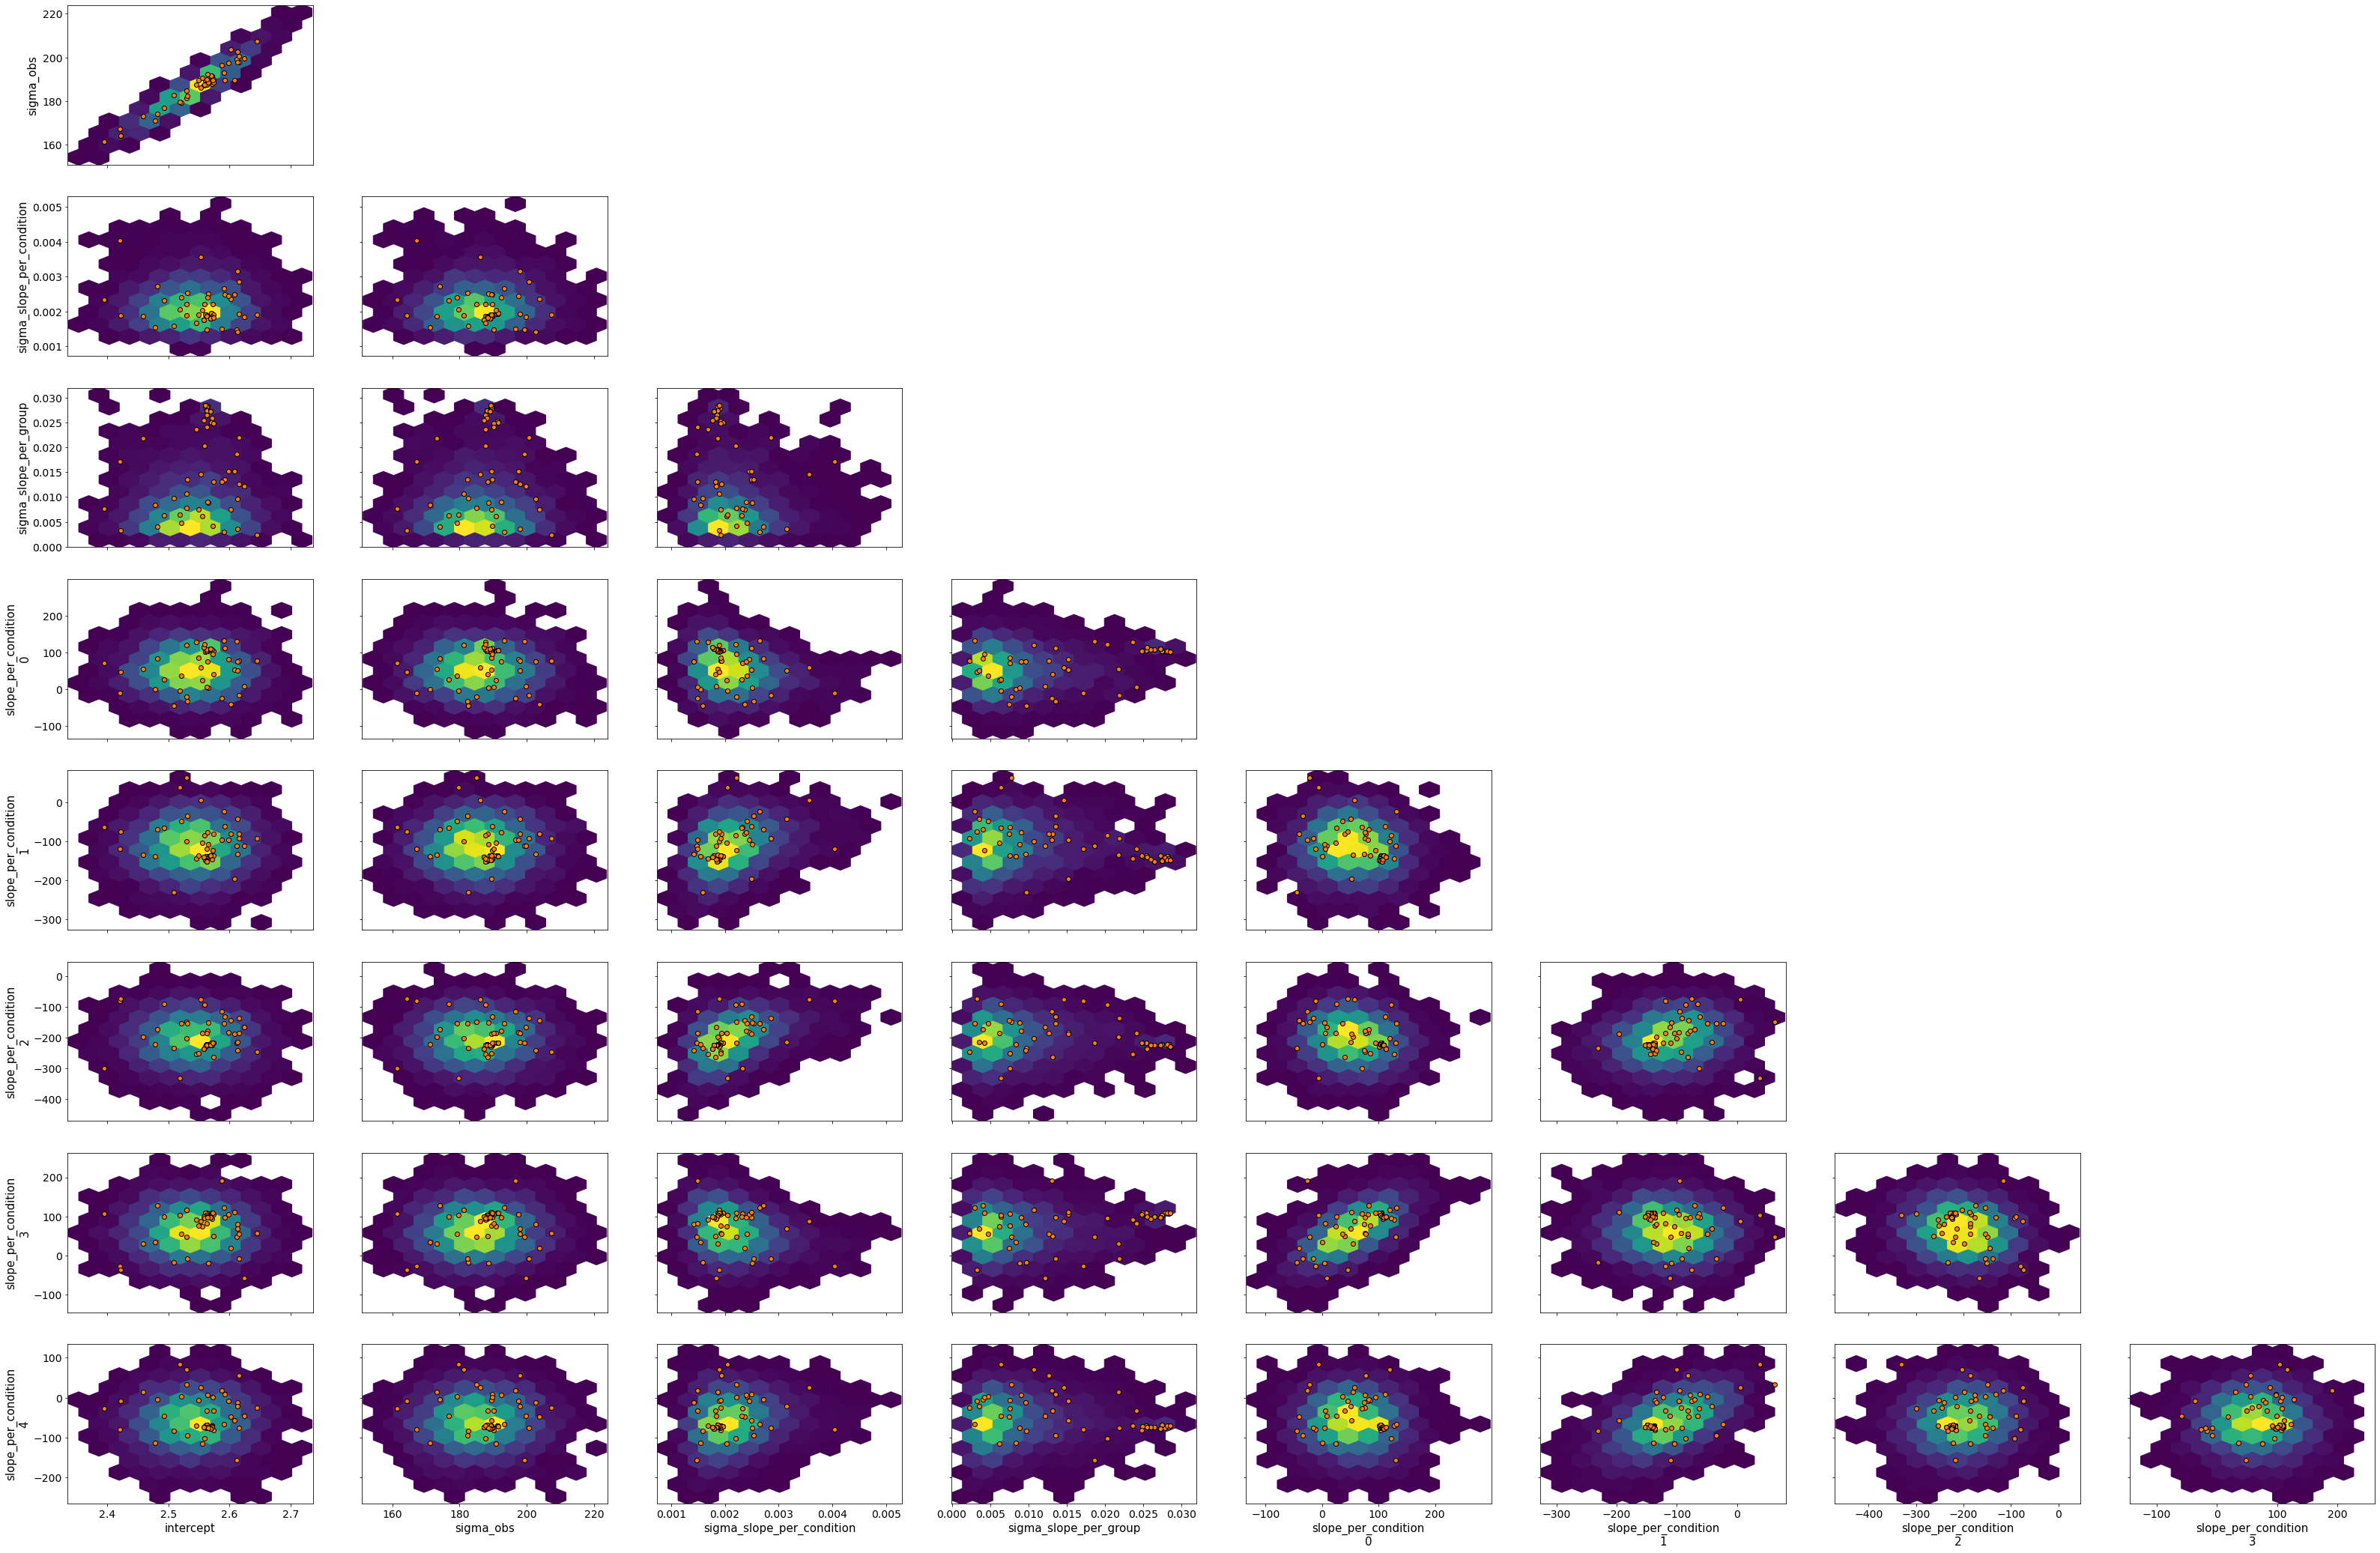

In [19]:
# Gamma GLM slope only
reload(models)
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='gamma',
              robust_slopes=False,
              add_group_intercept=False,
              add_group_slope=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

neuron:O


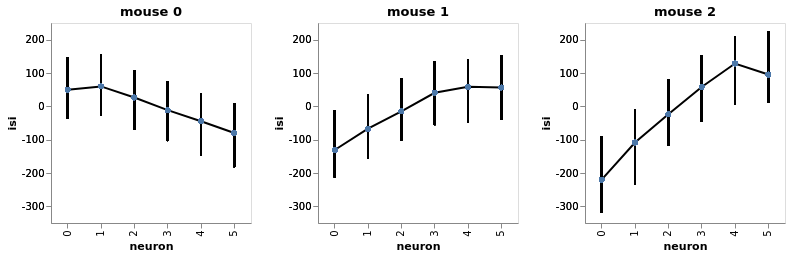

In [20]:
bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)
bw.facet(column='mouse',width=200,height=200).display()

n(Divergences) = 36
neuron:O


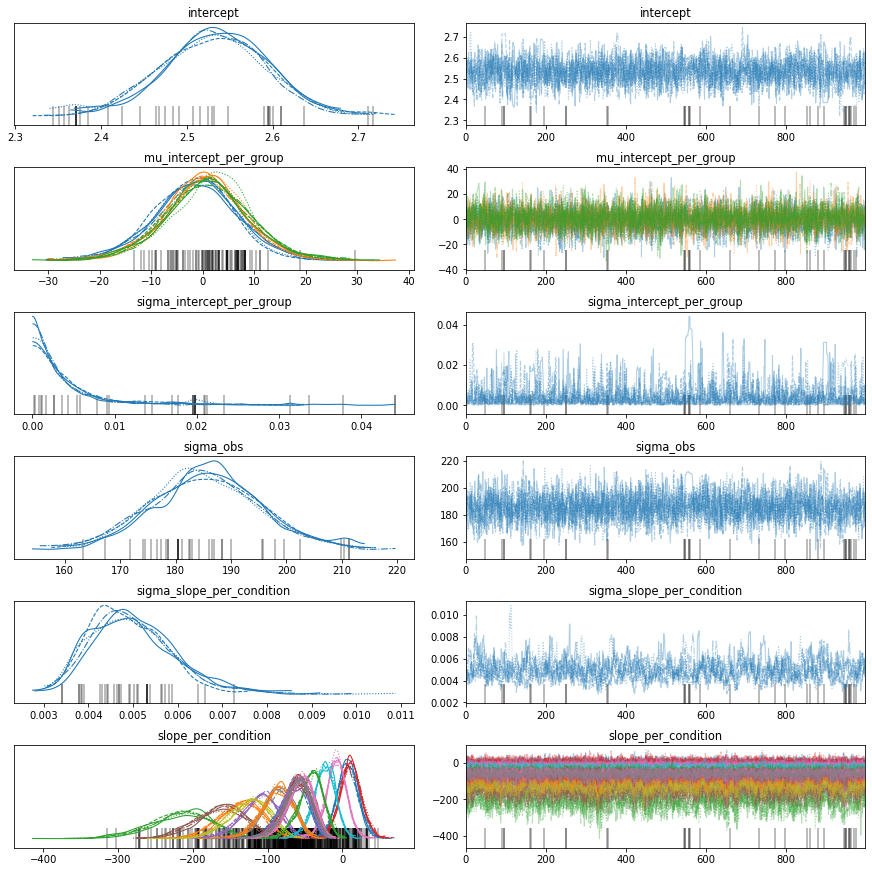

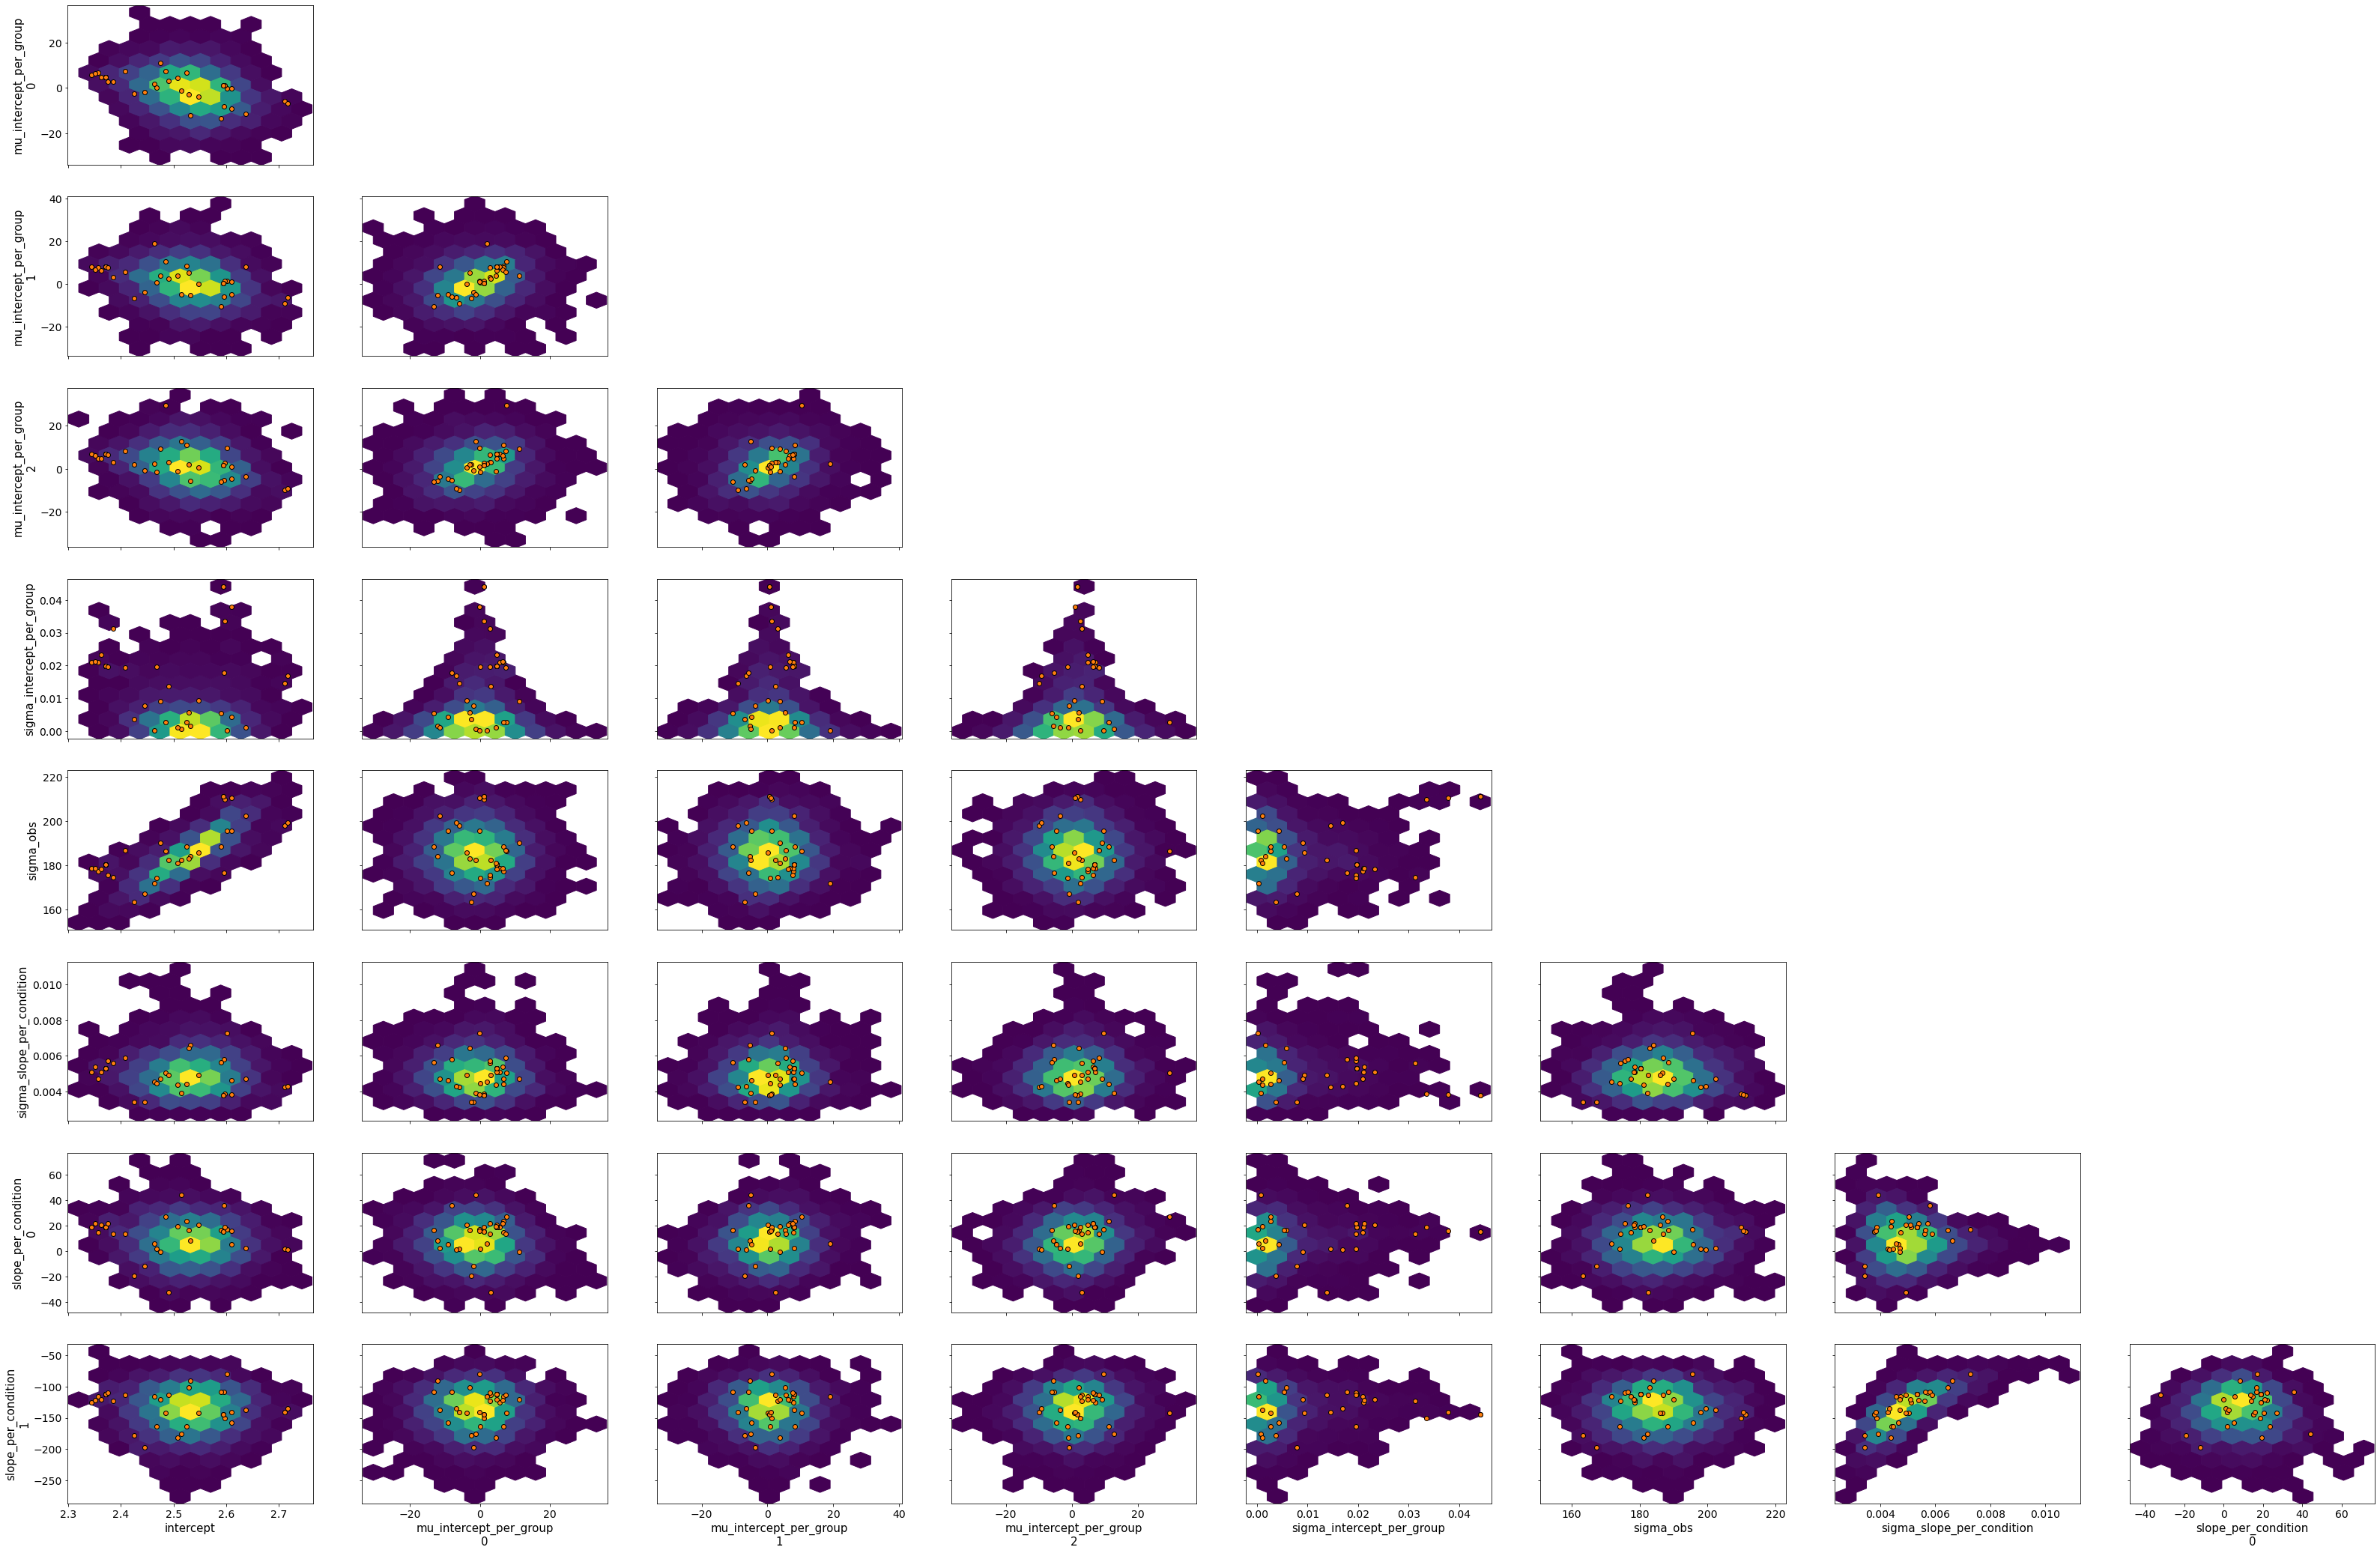

In [21]:
# Gamma GLM intercept only
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='gamma',
              robust_slopes=False,
              add_group_intercept=True,
              add_group_slope=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

group slopes+ group intercepts=>divergences

## LME fails

In [22]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron_x_mouse'], group='mouse',)
bw.fit_lme(add_data=False,add_group_intercept=True, add_group_slope=False)

Using formula isi ~ (1|mouse) + stim| neuron_x_mouse__0 + stim|neuron_x_mouse__1 + stim|neuron_x_mouse__2 + stim|neuron_x_mouse__3 + stim|neuron_x_mouse__4 + stim|neuron_x_mouse__5 + stim|neuron_x_mouse__6 + stim|neuron_x_mouse__7 + stim|neuron_x_mouse__8 + stim|neuron_x_mouse__9 + stim|neuron_x_mouse__10 + stim|neuron_x_mouse__11 + stim|neuron_x_mouse__12 + stim|neuron_x_mouse__13 + stim|neuron_x_mouse__14 + stim|neuron_x_mouse__15 + stim|neuron_x_mouse__16 + stim|neuron_x_mouse__17
                            Coef. Std.Err.        z  P>|z|  [0.025  0.975]
Intercept                   0.081    0.015    5.574  0.000   0.053   0.110
1 | mouse                  -0.007    0.008   -0.957  0.339  -0.022   0.008
stim | neuron_x_mouse__0    0.006    0.003    2.268  0.023   0.001   0.011
stim | neuron_x_mouse__1   -0.007    0.003   -2.502  0.012  -0.012  -0.001
stim | neuron_x_mouse__2   -0.015    0.003   -5.761  0.000  -0.020  -0.010
stim | neuron_x_mouse__3   -0.017    0.003   -6.567  0.000  -

neuron_x_mouse:O


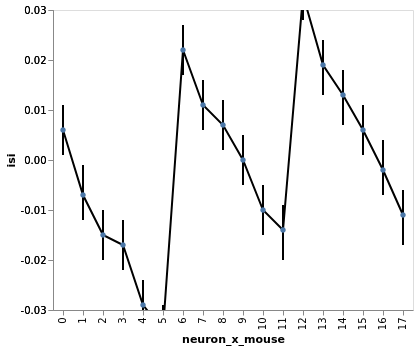

'Proper faceting will work when data addition is implemented in fit_lme()'

In [23]:
bw.regression_charts(x='neuron_x_mouse:O').display()
#bw.facet(column='mouse').display()
"Proper faceting will work when data addition is implemented in fit_lme()"

In [24]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron_x_mouse'], group='mouse',)
bw.fit_lme(add_data=False,add_group_intercept=True, add_group_slope=True)

Using formula isi ~ (stim|mouse)  + stim| neuron_x_mouse__0 + stim|neuron_x_mouse__1 + stim|neuron_x_mouse__2 + stim|neuron_x_mouse__3 + stim|neuron_x_mouse__4 + stim|neuron_x_mouse__5 + stim|neuron_x_mouse__6 + stim|neuron_x_mouse__7 + stim|neuron_x_mouse__8 + stim|neuron_x_mouse__9 + stim|neuron_x_mouse__10 + stim|neuron_x_mouse__11 + stim|neuron_x_mouse__12 + stim|neuron_x_mouse__13 + stim|neuron_x_mouse__14 + stim|neuron_x_mouse__15 + stim|neuron_x_mouse__16 + stim|neuron_x_mouse__17
                            Coef. Std.Err.        z  P>|z|  [0.025  0.975]
Intercept                   0.076    0.010    7.427  0.000   0.056   0.096
stim | mouse               -0.007    0.008   -0.957  0.339  -0.022   0.008
stim | neuron_x_mouse__0    0.004    0.003    1.087  0.277  -0.003   0.011
stim | neuron_x_mouse__1   -0.009    0.003   -2.504  0.012  -0.015  -0.002
stim | neuron_x_mouse__2   -0.017    0.003   -4.957  0.000  -0.024  -0.010
stim | neuron_x_mouse__3   -0.019    0.003   -5.564  0.00

neuron_x_mouse:O


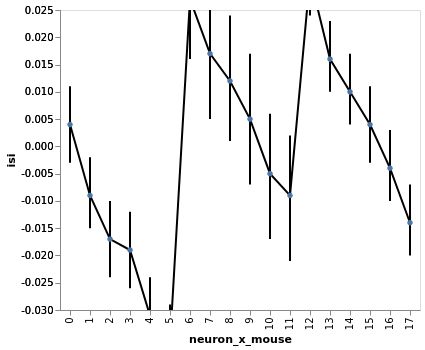

In [25]:
bw.regression_charts(x='neuron_x_mouse:O').display()

Need nested design, but get singular matrix:

In [26]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron_x_mouse'], group='mouse',)
try:
    bw.fit_lme(add_data=False,add_group_intercept=True, add_group_slope=True, add_nested_group=True)
except Exception as e:
    print(e)



Using formula isi ~ (stim|mouse) + stim| neuron_x_mouse__0:mouse + stim|neuron_x_mouse__1:mouse + stim|neuron_x_mouse__2:mouse + stim|neuron_x_mouse__3:mouse + stim|neuron_x_mouse__4:mouse + stim|neuron_x_mouse__5:mouse + stim|neuron_x_mouse__6:mouse + stim|neuron_x_mouse__7:mouse + stim|neuron_x_mouse__8:mouse + stim|neuron_x_mouse__9:mouse + stim|neuron_x_mouse__10:mouse + stim|neuron_x_mouse__11:mouse + stim|neuron_x_mouse__12:mouse + stim|neuron_x_mouse__13:mouse + stim|neuron_x_mouse__14:mouse + stim|neuron_x_mouse__15:mouse + stim|neuron_x_mouse__16:mouse + stim|neuron_x_mouse__17:mouse
Singular matrix
